In [11]:
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial

Taken from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [12]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [30]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 32 # was 4

image_datasets = {
        'train': torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train']),
        'val': torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['val']),
    }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True if x == 'train' else False, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    print("Using CPU! things will be slow! :(")

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



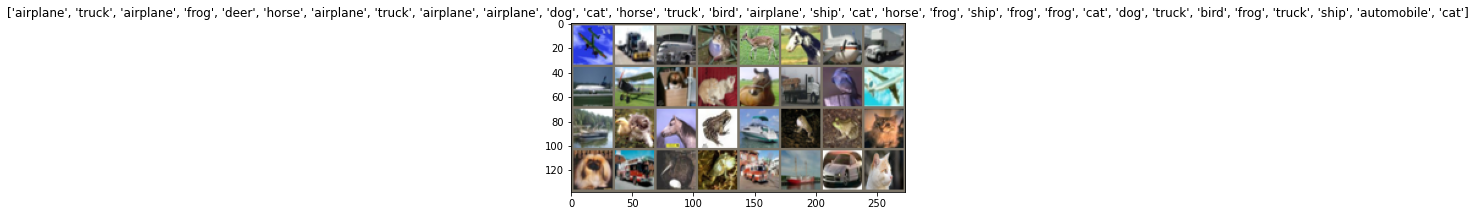

In [31]:
def imshow(inp, title=None, ax=plt):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images. Furthermore, let's also compute the accuracy on the test set.




In [42]:
def visualize_model(model, num_images=6, num_cols=3):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    total, correct = 0, 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):

                if preds[j] == labels.data[j]:
                    correct += 1
                total += 1                

                images_so_far += 1
                if images_so_far <= num_images:
                    color = 'green' if preds[j] == labels.data[j] else 'red' # if correct green, else red
                    ax = plt.subplot(num_images//num_cols, num_cols, images_so_far,  xticks=[], yticks=[])
                    #ax.axis('off')
                    ax.tick_params(color=color, labelcolor=color)
                    ax.set_title(f'pred.: {class_names[preds[j]]}', color = color)
                    imshow(inputs.cpu().data[j], ax=ax)

                    for spine in ax.spines.values():
                        spine.set_edgecolor(color)

        model.train(mode=was_training)
    plt.show()

    print(f'Accuracy: {correct/total*100:.1f}%')
    print(f"Correct: {correct}, Total: {total}")

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [48]:
model_ft = models.resnet18(weights='DEFAULT')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to the number of classes.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
# The last layer has random weights, so we need to retrain the network.

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Let's see how good our model performs right now (without training)

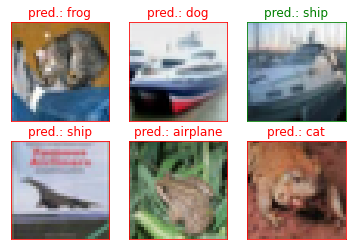

Accuracy: 7.1%
Correct: 708, Total: 10000


In [47]:
visualize_model(model_ft)

### Train and evaluate

It will take a while to train this network. On GPU though, it should be faster.

After training for 25 epochs, we get a val accuracy of >80%.




In [49]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0127 Acc: 0.6486
val Loss: 0.6653 Acc: 0.7749

Epoch 1/24
----------
train Loss: 0.6770 Acc: 0.7681
val Loss: 0.5993 Acc: 0.7942

Epoch 2/24
----------
train Loss: 0.5604 Acc: 0.8091
val Loss: 0.5578 Acc: 0.8082

Epoch 3/24
----------
train Loss: 0.4927 Acc: 0.8289
val Loss: 0.5244 Acc: 0.8185

Epoch 4/24
----------
train Loss: 0.4331 Acc: 0.8492
val Loss: 0.5227 Acc: 0.8246

Epoch 5/24
----------
train Loss: 0.3897 Acc: 0.8645
val Loss: 0.5260 Acc: 0.8224

Epoch 6/24
----------
train Loss: 0.3502 Acc: 0.8772
val Loss: 0.5045 Acc: 0.8337

Epoch 7/24
----------
train Loss: 0.2640 Acc: 0.9086
val Loss: 0.4792 Acc: 0.8423

Epoch 8/24
----------
train Loss: 0.2341 Acc: 0.9197
val Loss: 0.4747 Acc: 0.8442

Epoch 9/24
----------
train Loss: 0.2200 Acc: 0.9253
val Loss: 0.4734 Acc: 0.8446

Epoch 10/24
----------
train Loss: 0.2111 Acc: 0.9284
val Loss: 0.4789 Acc: 0.8451

Epoch 11/24
----------
train Loss: 0.1988 Acc: 0.9320
val Loss: 0.4853 Acc: 0.8456

Ep

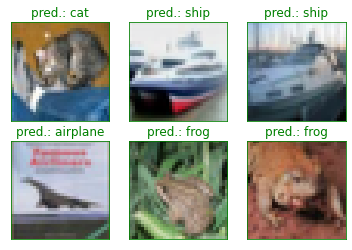

Accuracy: 84.9%
Correct: 8494, Total: 10000


In [50]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [52]:
model_conv = torchvision.models.resnet18(weights='DEFAULT')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
# Here the size of each output sample is set to the number of classes.
model_conv.fc = nn.Linear(num_ftrs, len(class_names))
# The last layer has random weights, so one option is to retrain the last layer only.

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

This will take less time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed as well.

After training for 25 epochs, we should get a lower accuracy as before. Very likely caused by the resolution difference between CIFAR10 and ImageNet.




In [53]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7335 Acc: 0.3915
val Loss: 1.6326 Acc: 0.4446

Epoch 1/24
----------
train Loss: 1.6304 Acc: 0.4281
val Loss: 1.6334 Acc: 0.4378

Epoch 2/24
----------
train Loss: 1.6156 Acc: 0.4338
val Loss: 1.6300 Acc: 0.4408

Epoch 3/24
----------
train Loss: 1.6099 Acc: 0.4378
val Loss: 1.5861 Acc: 0.4565

Epoch 4/24
----------
train Loss: 1.6021 Acc: 0.4395
val Loss: 1.5901 Acc: 0.4539

Epoch 5/24
----------
train Loss: 1.5978 Acc: 0.4400
val Loss: 1.5906 Acc: 0.4572

Epoch 6/24
----------
train Loss: 1.6044 Acc: 0.4407
val Loss: 1.5926 Acc: 0.4559

Epoch 7/24
----------
train Loss: 1.5563 Acc: 0.4553
val Loss: 1.5514 Acc: 0.4667

Epoch 8/24
----------
train Loss: 1.5391 Acc: 0.4634
val Loss: 1.5443 Acc: 0.4692

Epoch 9/24
----------
train Loss: 1.5397 Acc: 0.4602
val Loss: 1.5463 Acc: 0.4678

Epoch 10/24
----------
train Loss: 1.5401 Acc: 0.4616
val Loss: 1.5461 Acc: 0.4718

Epoch 11/24
----------
train Loss: 1.5420 Acc: 0.4622
val Loss: 1.5276 Acc: 0.4695

Ep

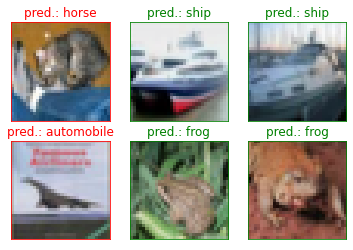

Accuracy: 48.1%
Correct: 4811, Total: 10000


In [54]:
visualize_model(model_conv)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [59]:
model_new = models.resnet18(weights=None)
# initialize the weight randomly

num_ftrs = model_new.fc.in_features
# Here the size of each output sample is set to the number of classes.
model_new.fc = nn.Linear(num_ftrs, len(class_names))
# The last layer has random weights, so we need to retrain the network.

model_new = model_new.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_new = optim.SGD(model_new.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_new, step_size=7, gamma=0.1)

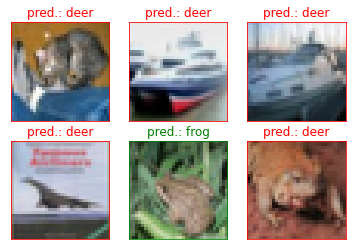

Accuracy: 9.4%
Correct: 939, Total: 10000


In [60]:
visualize_model(model_new)

In [61]:
model_new = train_model(model_new, criterion, optimizer_new,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5746 Acc: 0.4289
val Loss: 1.3058 Acc: 0.5240

Epoch 1/24
----------
train Loss: 1.2340 Acc: 0.5622
val Loss: 1.1182 Acc: 0.6046

Epoch 2/24
----------
train Loss: 1.0677 Acc: 0.6247
val Loss: 0.9908 Acc: 0.6465

Epoch 3/24
----------
train Loss: 0.9362 Acc: 0.6703
val Loss: 0.9396 Acc: 0.6656

Epoch 4/24
----------
